Import the required libraries

In [1]:
import tempfile
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import time as timer
from sklearn.inspection import permutation_importance

In [2]:
print(tf.version.VERSION)

2.7.0


Load dataset from kaggle or elsewhere

In [3]:
# Load dataset from kaggle or elsewhere
url = "https://raw.githubusercontent.com/robotAstray/ICL-DataCompetition/main/music_genre%5B1%5D.csv"
data = pd.read_csv(url)
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


# Audio Features

We use `data.describe()` and encode non numerical columns to get an insight on the audio features: *popularity, acousticness, danceability,duration_ms, energy, instrumentalness, liveness,  loudness, speechiness,valence, mode, key, tempo*

In [4]:
data.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


In [5]:
data.isnull().sum()

instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64

There are 12 unique values, while the rest can be discarted

In [6]:
# There are 12 unique values, while the rest can be discarted

miss_val = data.isnull().sum()/len(data)*100
print(miss_val)
print("# Missing values in variable danceability\t\t: {:.2f}%".format(miss_val['danceability']))
print("# Missing values in variable mode\t\t: {:.2f}%".format(miss_val['mode']))
print("# Missing values in variable key\t\t: {:.2f}%".format(miss_val['key']))
print("# Missing values in variable tempo\t: {:.2f}%".format(miss_val['tempo']))
print("# Missing values in variable instance_id\t: {:.2f}%".format(miss_val['instance_id']))
print("Data shape: {}".format(data.shape))

instance_id         0.009999
artist_name         0.009999
track_name          0.009999
popularity          0.009999
acousticness        0.009999
danceability        0.009999
duration_ms         0.009999
energy              0.009999
instrumentalness    0.009999
key                 0.009999
liveness            0.009999
loudness            0.009999
mode                0.009999
speechiness         0.009999
tempo               0.009999
obtained_date       0.009999
valence             0.009999
music_genre         0.009999
dtype: float64
# Missing values in variable danceability		: 0.01%
# Missing values in variable mode		: 0.01%
# Missing values in variable key		: 0.01%
# Missing values in variable tempo	: 0.01%
# Missing values in variable instance_id	: 0.01%
Data shape: (50005, 18)


We drop the rows were instance_id is missing or other information is missing

In [7]:
pd.options.mode.chained_assignment = None 
updated_data = data[data['music_genre'].notnull()]
# drop 'instace_id' if it does not exist
updated_data.drop(columns='instance_id',axis=1,inplace=True)
# check for missing values
miss_val = updated_data.isnull().sum()/len(updated_data)*100
print(miss_val)
print("Shape of data frame without missing elements: {}".format(updated_data.shape))

artist_name         0.0
track_name          0.0
popularity          0.0
acousticness        0.0
danceability        0.0
duration_ms         0.0
energy              0.0
instrumentalness    0.0
key                 0.0
liveness            0.0
loudness            0.0
mode                0.0
speechiness         0.0
tempo               0.0
obtained_date       0.0
valence             0.0
music_genre         0.0
dtype: float64
Shape of data frame without missing elements: (50000, 17)


In [8]:
# There were 5 instance_id missing and we have dropped them from the dataset.

print("Unique 'artist_name': {}".format(updated_data['artist_name'].unique()))
print("Unique 'track_name': {}".format(updated_data['track_name'].unique()))
print("Unique 'key': {}".format(updated_data['key'].unique()))
print("Unique 'mode': {}".format(updated_data['mode'].unique()))
print("Unique 'music_genre': {}".format(updated_data['music_genre'].unique()))
print("Unique 'obtained_date': {}".format(updated_data['obtained_date'].unique()))



Unique 'artist_name': ['Röyksopp' 'Thievery Corporation' 'Dillon Francis' ... 'Darshan Raval'
 'Powers Pleasant' 'Millonario']
Unique 'track_name': ["Röyksopp's Night Out" 'The Shining Path' 'Hurricane' ...
 'Drama (feat. Drake)' "Lovin' Me (feat. Smiggz)" 'Hip Hop Hooray']
Unique 'key': ['A#' 'D' 'G#' 'C#' 'F#' 'B' 'G' 'F' 'A' 'C' 'E' 'D#']
Unique 'mode': ['Minor' 'Major']
Unique 'music_genre': ['Electronic' 'Anime' 'Jazz' 'Alternative' 'Country' 'Rap' 'Blues' 'Rock'
 'Classical' 'Hip-Hop']
Unique 'obtained_date': ['4-Apr' '3-Apr' '5-Apr' '1-Apr' '0/4']


In [9]:
# Drop labels that will not contribute to the machine learning model
updated_data = updated_data.drop(labels='track_name', axis=1)
updated_data = updated_data.drop(labels='artist_name', axis=1)
updated_data = updated_data.drop(labels='obtained_date', axis=1)

In [10]:
updated_data.shape

(50000, 14)

check the data type of each column make sure int64 and objects are now float64

In [11]:

updated_data.dtypes

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
valence             float64
music_genre          object
dtype: object

convert `updated_data['tempo']` from object to float64

In [12]:
updated_data['tempo']= updated_data['tempo'].apply(lambda col:pd.to_numeric(col, errors='coerce'))

In [13]:
updated_data['tempo'].dtypes

dtype('float64')

Declare an Encoder for the labels above and encode non numerical column 

In [14]:
label_mode = LabelEncoder()
label_music_genre = LabelEncoder()
label_tempo = LabelEncoder()
label_key = LabelEncoder()



In [15]:
updated_data['key']= label_key.fit_transform(updated_data['key'])
updated_data['mode']= label_mode.fit_transform(updated_data['mode'])
updated_data['tempo']= label_mode.fit_transform(updated_data['tempo'])
updated_data['music_genre']= label_mode.fit_transform(updated_data['music_genre'])

updated_data.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,-1.0,0.941,0.79200,1,0.115,-5.201,1,0.0748,9750,0.759,5
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,5,0.124,-7.043,1,0.0300,13669,0.531,5
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,11,0.534,-4.617,0,0.0345,17614,0.333,5
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,4,0.157,-4.498,0,0.2390,17634,0.270,5
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,9,0.157,-6.266,0,0.0413,22497,0.323,5


In [16]:

updated_data['key'] = updated_data['key'].astype(np.float64)

updated_data['mode'] = updated_data['mode'].astype(np.float64)

In [17]:
with pd.option_context('expand_frame_repr', False):
    print(updated_data.head())

   popularity  acousticness  danceability  duration_ms  energy  instrumentalness   key  liveness  loudness  mode  speechiness  tempo  valence  music_genre
0        27.0       0.00468         0.652         -1.0   0.941           0.79200   1.0     0.115    -5.201   1.0       0.0748   9750    0.759            5
1        31.0       0.01270         0.622     218293.0   0.890           0.95000   5.0     0.124    -7.043   1.0       0.0300  13669    0.531            5
2        28.0       0.00306         0.620     215613.0   0.755           0.01180  11.0     0.534    -4.617   0.0       0.0345  17614    0.333            5
3        34.0       0.02540         0.774     166875.0   0.700           0.00253   4.0     0.157    -4.498   0.0       0.2390  17634    0.270            5
4        32.0       0.00465         0.638     222369.0   0.587           0.90900   9.0     0.157    -6.266   0.0       0.0413  22497    0.323            5


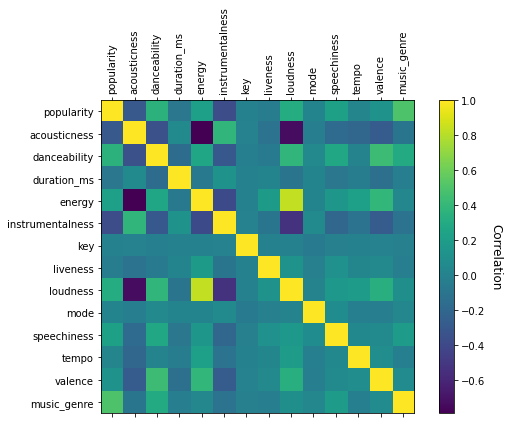

In [18]:
# Plot relationships between labels 

fig, ax = plt.subplots(figsize=(8,6))
im = ax.matshow(updated_data.corr())
ax.set_xticks(np.arange(updated_data.shape[1]))
ax.set_yticks(np.arange(updated_data.shape[1]))
ax.set_xticklabels(updated_data.columns,rotation=90)
ax.set_yticklabels(updated_data.columns)
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom", fontsize=12)
fig.tight_layout()
plt.show()

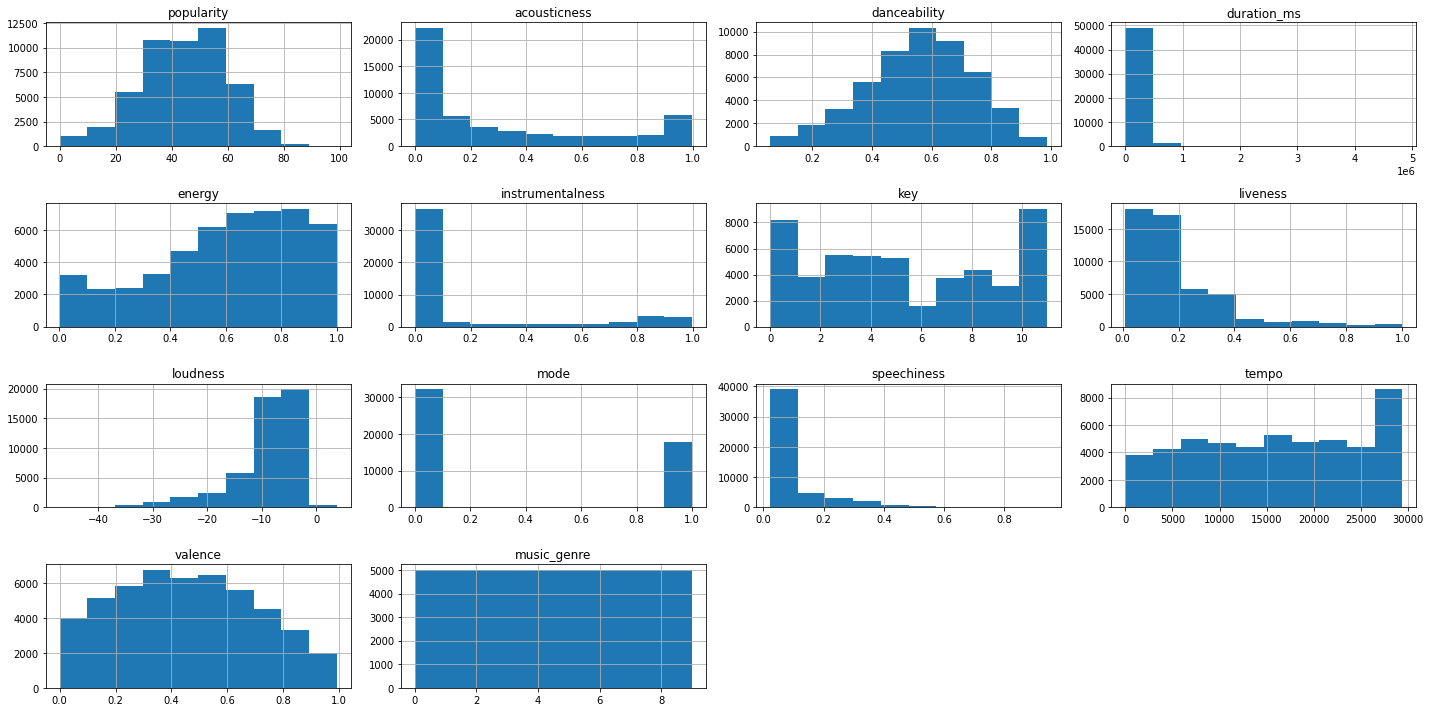

In [19]:


fig = updated_data.hist(figsize=(20,10))
plt.tight_layout()
plt.show()



In [20]:
df=updated_data[['popularity', 'acousticness', 'danceability','duration_ms', 'energy', 'instrumentalness', 'key', 'liveness','loudness','mode','speechiness','tempo', 'valence', 'music_genre']]

In [21]:
# Normalise dataset
normdf = df.apply(lambda x: x/x.max(), axis=0)
normdf

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,0.272727,0.004699,0.661258,-2.070134e-07,0.941942,0.795181,0.090909,0.115,-1.389156,1.0,0.079406,0.331712,0.765121,0.555556
1,0.313131,0.012751,0.630832,4.518957e-02,0.890891,0.953815,0.454545,0.124,-1.881143,1.0,0.031847,0.465043,0.535282,0.555556
2,0.282828,0.003072,0.628803,4.463477e-02,0.755756,0.011847,1.000000,0.534,-1.233173,0.0,0.036624,0.599258,0.335685,0.555556
3,0.343434,0.025502,0.784990,3.454536e-02,0.700701,0.002540,0.363636,0.157,-1.201389,0.0,0.253715,0.599939,0.272177,0.555556
4,0.323232,0.004669,0.647059,4.603335e-02,0.587588,0.912651,0.818182,0.157,-1.673611,0.0,0.043843,0.765386,0.325605,0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,0.595960,0.033534,0.925963,-2.070134e-07,0.574575,0.000000,0.363636,0.119,-1.875534,0.0,0.316348,0.303848,0.332661,0.666667
50001,0.727273,0.157631,0.719067,5.213839e-02,0.362362,0.000000,0.181818,0.109,-2.621261,0.0,0.058386,0.536965,0.113911,0.666667
50002,0.515152,0.005994,0.702840,3.922551e-02,0.763764,0.000000,0.454545,0.143,-1.453793,0.0,0.154989,0.631647,0.398185,0.666667
50003,0.656566,0.083434,0.793103,5.439752e-02,0.472472,0.000000,0.909091,0.106,-1.339744,1.0,0.046815,0.061885,0.356855,0.666667


In [22]:
normdf.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,0.272727,0.004699,0.661258,-2.070134e-07,0.941942,0.795181,0.090909,0.115,-1.389156,1.0,0.079406,0.331712,0.765121,0.555556
1,0.313131,0.012751,0.630832,4.518957e-02,0.890891,0.953815,0.454545,0.124,-1.881143,1.0,0.031847,0.465043,0.535282,0.555556
2,0.282828,0.003072,0.628803,4.463477e-02,0.755756,0.011847,1.000000,0.534,-1.233173,0.0,0.036624,0.599258,0.335685,0.555556
3,0.343434,0.025502,0.784990,3.454536e-02,0.700701,0.002540,0.363636,0.157,-1.201389,0.0,0.253715,0.599939,0.272177,0.555556
4,0.323232,0.004669,0.647059,4.603335e-02,0.587588,0.912651,0.818182,0.157,-1.673611,0.0,0.043843,0.765386,0.325605,0.555556


In [23]:
updated_data.shape,normdf.shape

((50000, 14), (50000, 14))

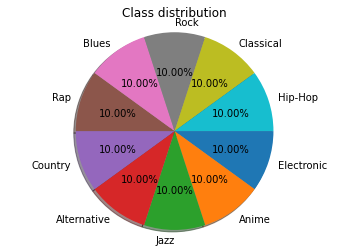

# samples associated with Electronic: 5000
# samples associated with Anime: 5000
# samples associated with Jazz: 5000
# samples associated with Alternative: 5000
# samples associated with Country: 5000
# samples associated with Rap: 5000
# samples associated with Blues: 5000
# samples associated with Rock: 5000


In [24]:
class_occur = df['music_genre'].value_counts()
class_names = ['Electronic','Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock',
 'Classical', 'Hip-Hop']
fig, ax = plt.subplots()
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%', shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with Electronic: {}".format(class_occur[0]))
print("# samples associated with Anime: {}".format(class_occur[1]))
print("# samples associated with Jazz: {}".format(class_occur[2]))
print("# samples associated with Alternative: {}".format(class_occur[3]))
print("# samples associated with Country: {}".format(class_occur[4]))
print("# samples associated with Rap: {}".format(class_occur[5]))
print("# samples associated with Blues: {}".format(class_occur[6]))
print("# samples associated with Rock: {}".format(class_occur[7]))


In [25]:
y=df['music_genre']
x=df.drop('music_genre',axis=1)
x.shape,y.shape



((50000, 13), (50000,))

In [26]:


# from sklearn.model_selection import train_test_split as tts
# x_train,x_test,y_train,y_test=tts(x,y,test_size=0.2)
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

def split_train_valid_test(X,y,test_size=0.1,random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=test_size/(1-test_size), random_state=random_state, stratify=y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(x,y,test_size=0.1,random_state=42)
_, train_counts = np.unique(y_train, return_counts=True)
_, valid_counts = np.unique(y_valid, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
print("[train] # class 0: {} | # class 1: {}".format(train_counts[0],train_counts[1]))
print("[valid] # class 0: {} | # class 1: {}".format(valid_counts[0],valid_counts[1]))
print("[test]  # class 0: {} | # class 1: {}".format(test_counts[0],test_counts[1]))

[train] # class 0: 4000 | # class 1: 4000
[valid] # class 0: 500 | # class 1: 500
[test]  # class 0: 500 | # class 1: 500


The following Models will be implemented:

    Gaussian Naive Bayes (GNB)
    Logistic Regression (LR)
    Decision Tree (DT)
    Random Forest (RF)
    LightGBM (LGBM)
    XGboost (XGB)


In [27]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

# Gaussian Naive Bayes (GNB)

In [28]:
start = timer.time()
gnb_model = GaussianNB()
gnb_model.fit(X_train_std, y_train)
end = timer.time()
print("Training time {:.2f} seconds".format(end-start))
# Predicting the test set results
y_gnb = gnb_model.predict(X_test_std)
y_gnb_prob = gnb_model.predict_proba(X_test_std)

Training time 0.06 seconds


In [29]:
print("GNB Classification report: \n{}".format(classification_report(y_test,y_gnb)))
print("GNB Confusion matrix: \n{}".format(confusion_matrix(y_test,y_gnb)))
print("GNB Accuracy score: {:.2f}".format(accuracy_score(y_test,y_gnb)))


GNB Classification report: 
              precision    recall  f1-score   support

           0       0.42      0.21      0.28       500
           1       0.66      0.35      0.46       500
           2       0.45      0.23      0.30       500
           3       0.67      0.88      0.76       500
           4       0.29      0.80      0.42       500
           5       0.51      0.46      0.48       500
           6       0.40      0.36      0.38       500
           7       0.45      0.32      0.38       500
           8       0.40      0.47      0.43       500
           9       0.57      0.37      0.45       500

    accuracy                           0.45      5000
   macro avg       0.48      0.45      0.43      5000
weighted avg       0.48      0.45      0.43      5000

GNB Confusion matrix: 
[[105   3  16   5 190  28  48  18  30  57]
 [ 11 176  29  92 138  44   0   8   2   0]
 [ 15  42 113  24 204  35   2  55   2   8]
 [  6   5   6 440  13  14   0  16   0   0]
 [ 19   4  14   4 

# Logistic Regressions (LR)

In [30]:
start = timer.time()
logit_model = LogisticRegression(solver='lbfgs', random_state=42)
logit_model.fit(X_train_std, y_train)
end = timer.time()
print("Training time {:.2f} seconds".format(end-start))
# Predicting the test set results
y_logit = logit_model.predict(X_test_std)
y_logit_prob = logit_model.predict_proba(X_test_std)

Training time 8.76 seconds


In [31]:


print("LR Classification report: \n{}".format(classification_report(y_test,y_logit)))
print("LR Confusion matrix: \n{}".format(confusion_matrix(y_test,y_logit)))
print("LR Accuracy score: {:.2f}".format(accuracy_score(y_test,y_logit)))

LR Classification report: 
              precision    recall  f1-score   support

           0       0.41      0.33      0.36       500
           1       0.60      0.61      0.61       500
           2       0.49      0.46      0.48       500
           3       0.78      0.81      0.80       500
           4       0.45      0.58      0.51       500
           5       0.56      0.57      0.57       500
           6       0.45      0.47      0.46       500
           7       0.50      0.41      0.45       500
           8       0.44      0.36      0.40       500
           9       0.54      0.69      0.61       500

    accuracy                           0.53      5000
   macro avg       0.52      0.53      0.52      5000
weighted avg       0.52      0.53      0.52      5000

LR Confusion matrix: 
[[163   4   9   1 121  32  41  31  13  85]
 [ 16 307  57  56  16  35   0  11   1   1]
 [  9  99 230   7  48  27   0  56   0  24]
 [  7  30  13 405   5  14   0  24   0   2]
 [ 33  10  57   1 28

# Decision Tree Classifier (DT)


In [32]:
start = timer.time()
dtree_model = DecisionTreeClassifier(random_state=42)
dtree_model.fit(X_train_std, y_train)
end = timer.time()
print("Training time {:.2f} seconds".format(end-start))
# Predicting the test set results
y_dtree = dtree_model.predict(X_test_std)
y_dtree_prob = dtree_model.predict_proba(X_test_std)

Training time 1.43 seconds


In [33]:
print("DT Classification report: \n{}".format(classification_report(y_test,y_dtree)))
print("DT Confusion matrix: \n{}".format(confusion_matrix(y_test,y_dtree)))
print("DT Accuracy score: {:.2f}".format(accuracy_score(y_test,y_dtree)))

DT Classification report: 
              precision    recall  f1-score   support

           0       0.30      0.32      0.31       500
           1       0.65      0.64      0.65       500
           2       0.38      0.39      0.39       500
           3       0.74      0.73      0.73       500
           4       0.43      0.45      0.44       500
           5       0.44      0.46      0.45       500
           6       0.28      0.27      0.28       500
           7       0.37      0.37      0.37       500
           8       0.29      0.28      0.28       500
           9       0.42      0.36      0.39       500

    accuracy                           0.43      5000
   macro avg       0.43      0.43      0.43      5000
weighted avg       0.43      0.43      0.43      5000

DT Confusion matrix: 
[[160  16  25   6  69  38  38  36  34  78]
 [  9 321  55  39  12  43   2  16   1   2]
 [ 23  52 195  25  44  60   2  82   0  17]
 [  9  42  25 364   6   8   0  43   0   3]
 [ 72  14  56   6 22

# Random Forest (RF)


In [34]:


start = timer.time()
ranfor_model = RandomForestClassifier(n_estimators=100, random_state=42)
ranfor_model.fit(X_train_std, y_train)
end = timer.time()
print("Training time {:.2f} seconds".format(end-start))
# Predicting the test set results
y_ranfor = ranfor_model.predict(X_test_std)
y_ranfor_prob = ranfor_model.predict_proba(X_test_std)



Training time 17.03 seconds


In [35]:
print("RF Classification report: \n{}".format(classification_report(y_test,y_ranfor)))
print("RF Confusion matrix: \n{}".format(confusion_matrix(y_test,y_ranfor)))
print("RF Accuracy score: {:.2f}".format(accuracy_score(y_test,y_ranfor)))

RF Classification report: 
              precision    recall  f1-score   support

           0       0.46      0.41      0.43       500
           1       0.78      0.76      0.77       500
           2       0.61      0.56      0.58       500
           3       0.85      0.85      0.85       500
           4       0.61      0.60      0.60       500
           5       0.63      0.60      0.61       500
           6       0.34      0.36      0.35       500
           7       0.54      0.56      0.55       500
           8       0.31      0.29      0.30       500
           9       0.52      0.65      0.58       500

    accuracy                           0.56      5000
   macro avg       0.56      0.56      0.56      5000
weighted avg       0.56      0.56      0.56      5000

RF Confusion matrix: 
[[203  10  13   0  61  25  40  26  26  96]
 [ 11 379  30  34   6  25   0  12   1   2]
 [ 15  39 279  10  30  34   1  64   0  28]
 [  8  16  10 425   1   9   0  28   1   2]
 [ 37   9  32   0 30

# LightGBM (LGBM)


In [36]:


start = timer.time()
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(X_train_std, y_train)
end = timer.time()
print("Training time {:.2f} seconds".format(end-start))
# Predicting the test set results
y_lgbm = lgbm_model.predict(X_test_std)
y_lgbm_prob = lgbm_model.predict_proba(X_test_std)



Training time 6.76 seconds


In [37]:


print("LGBM Classification report: \n{}".format(classification_report(y_test,y_lgbm)))
print("LGBM Confusion matrix: \n{}".format(confusion_matrix(y_test,y_lgbm)))
print("LGBM Accuracy score: {:.2f}".format(accuracy_score(y_test,y_lgbm)))

LGBM Classification report: 
              precision    recall  f1-score   support

           0       0.52      0.41      0.46       500
           1       0.80      0.77      0.78       500
           2       0.63      0.56      0.59       500
           3       0.85      0.86      0.85       500
           4       0.60      0.58      0.59       500
           5       0.65      0.62      0.63       500
           6       0.40      0.42      0.41       500
           7       0.57      0.57      0.57       500
           8       0.40      0.42      0.41       500
           9       0.55      0.73      0.62       500

    accuracy                           0.59      5000
   macro avg       0.60      0.59      0.59      5000
weighted avg       0.60      0.59      0.59      5000

LGBM Confusion matrix: 
[[206   8   9   2  63  21  48  29  23  91]
 [ 10 383  32  29   9  24   0  11   1   1]
 [ 17  40 278   6  38  36   1  58   0  26]
 [  7  16  11 429   1  11   1  22   0   2]
 [ 40   7  29   

# XGboost (XGB)

In [38]:


start = timer.time()
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_std, y_train)
end = timer.time()
print("Training time {:.2f} seconds".format(end-start))
# Predicting the test set results
y_xgb = xgb_model.predict(X_test_std)
y_xgb_prob = xgb_model.predict_proba(X_test_std)



Training time 25.62 seconds


In [39]:
print("XGB Classification report: \n{}".format(classification_report(y_test,y_xgb)))
print("XGB Confusion matrix: \n{}".format(confusion_matrix(y_test,y_xgb)))
print("XGB Accuracy score: {:.2f}".format(accuracy_score(y_test,y_xgb)))

XGB Classification report: 
              precision    recall  f1-score   support

           0       0.50      0.37      0.43       500
           1       0.78      0.73      0.76       500
           2       0.63      0.55      0.59       500
           3       0.83      0.83      0.83       500
           4       0.59      0.58      0.58       500
           5       0.62      0.59      0.61       500
           6       0.42      0.44      0.43       500
           7       0.52      0.50      0.51       500
           8       0.43      0.42      0.42       500
           9       0.53      0.80      0.63       500

    accuracy                           0.58      5000
   macro avg       0.59      0.58      0.58      5000
weighted avg       0.59      0.58      0.58      5000

XGB Confusion matrix: 
[[187   4   3   1  69  27  49  33  23 104]
 [ 10 365  38  32  16  20   1  15   1   2]
 [ 21  44 274   8  37  36   2  51   0  27]
 [ 10  19  11 416   0  10   1  30   0   3]
 [ 36   5  18   1 

# K- Nearest Neighbors Algorithm [Try out]

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics 

In [41]:
k_range = range(1,100)
scores = {}
scores_list = []


In [42]:
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))

Text(0, 0.5, 'Testing Accuracy')

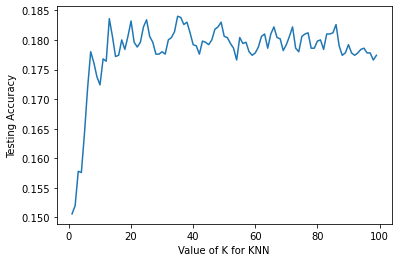

In [43]:
%matplotlib inline

plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [44]:
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=40)

In [45]:
# cross_validate
cv_scores = cross_val_score(knn, X_train, y_train, cv=10)

cv_scores_mean = np.mean(cv_scores)
print(cv_scores , "\n\n""mean =" ,"{:.2f}".format(cv_scores_mean))

[0.17425 0.171   0.177   0.1715  0.1755  0.165   0.18475 0.1795  0.1805
 0.17375] 

mean = 0.18


In [46]:
predictions = knn.predict(X_test)

accuracy_score = knn.score(X_test, y_test)
print("Accuracy score = ""{:.2f}".format(accuracy_score))


Accuracy score = 0.18
